# Criticism: evaluating model accuracy

In [1]:
from collections import OrderedDict
from pprint import pprint
import pyro
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from pyroed.datasets.data import load_tf_data
from pyroed.constraints import AllDifferent, Iff, IfThen, TakesValue
from pyroed.criticism import criticize
from pyroed.testing import generate_fake_data

matplotlib.rcParams["figure.facecolor"] = "white"

### Transcription factor data

We consider data from [Survey of variation in human transcription factors reveals prevalent DNA binding changes](https://www.science.org/doi/abs/10.1126/science.aad2257),
in particular for the PBX4 transcription factor.
The dataset consists of measurements of the binding affinities of PBX4 to all
possible DNA sequences of length 8, i.e. for a total of $4^8 = 65536$ sequences.
Since this dataset is exhaustive we can use it to do a semi-synthetic experiment in which
we first "measure" a small number of binding affinities and then do additional "experiments" in multiple rounds.

In [2]:
data = load_tf_data(data_dir="../pyroed/datasets")

In [3]:
for k, v in data.items():
    print(f"{k} {v.dtype} {tuple(v.shape)}")

sequences torch.int64 (65792, 8)
responses torch.float32 (65792,)
batch_ids torch.int64 (65792,)


In [4]:
set(data["batch_ids"].tolist())

{0}

Note that there are actually more than $65536$ data points due to some repeats.

Sequences take values 0,1,2,3 corresponding to nucleotides.

In [5]:
set(data["sequences"].reshape(-1).tolist())

{0, 1, 2, 3}

## Modeling in pyroed

Specify the design space via SCHEMA and FEATURE_BLOCKS.

In [6]:
SCHEMA = OrderedDict()
for n in range(8):
    SCHEMA[f"Nucleotide{n}"] = ["A", "C", "G", "T"]

singletons = [[name] for name in SCHEMA]
pairs = [list(ns) for ns in zip(SCHEMA, list(SCHEMA)[1:])]
FEATURE_BLOCKS = singletons + pairs

Let's start with a random subsample of data.

In [7]:
pyro.set_rng_seed(0)
full_size = len(data["responses"])
train_size = 100
test_size = 100
ids = torch.randperm(full_size)[:train_size + test_size]
train_ids = ids[:train_size]
test_ids = ids[train_size:]
experiment = {k: v[train_ids] for k, v in data.items()}
test_data = {k: v[test_ids] for k, v in data.items()}
print(f"Best response = {experiment['responses'].max():0.6g}")

Best response = 0.976619


svi step 0 loss = 1478.85
svi step 100 loss = 548.706
svi step 200 loss = 477.591
svi step 300 loss = 453.76
svi step 400 loss = 460.98
svi step 500 loss = 446.486
CPU times: user 7.59 s, sys: 227 ms, total: 7.82 s
Wall time: 7.58 s


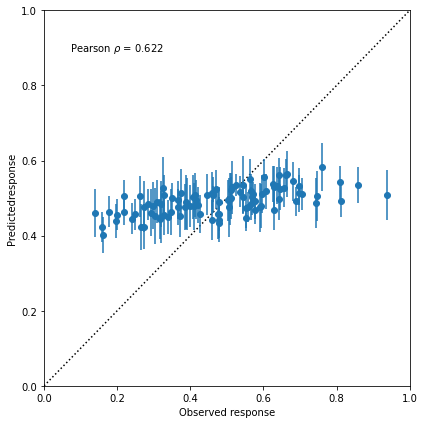

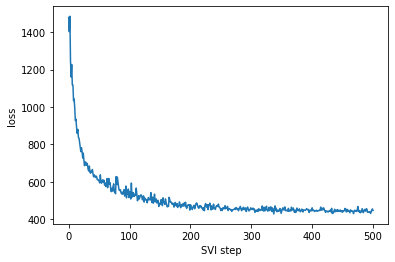

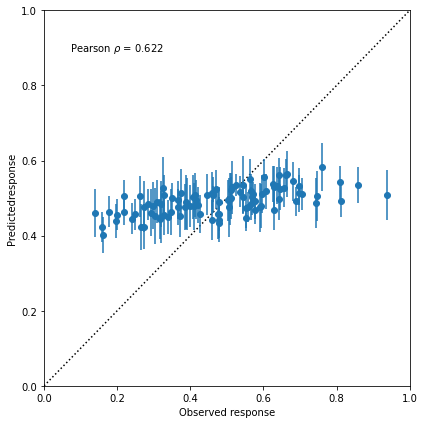

In [8]:
%%time
criticize(SCHEMA, FEATURE_BLOCKS, experiment, test_data, svi_reparam=True);

svi step 0 loss = 1702.4
svi step 100 loss = 512.15
svi step 200 loss = 463.478
svi step 300 loss = 466.558
svi step 400 loss = 442.278
svi step 500 loss = 448.55


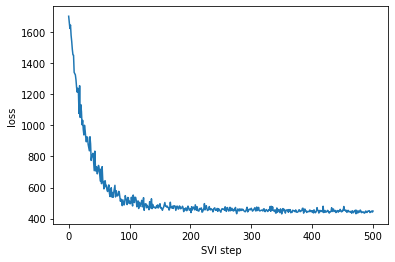

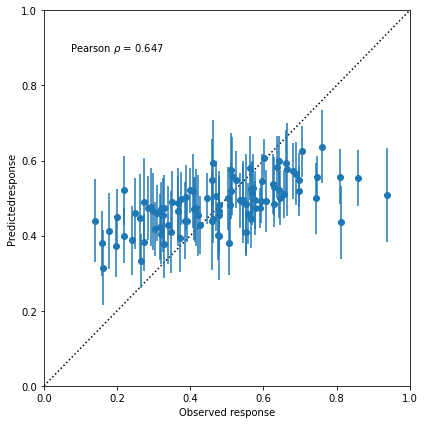

In [9]:
criticize(SCHEMA, FEATURE_BLOCKS, experiment, test_data, svi_reparam=False);